In [5]:
### fix how M values is taken in
### Switch to Jupyter Notebook
### Import Data
### Make a special data file with only 10 events or so
### Plot the raw signals from those 10 events
### Plot resulting Trapezoids
# figure out calibration
# Plot the full, calibrated energy spectra for Co, Cs, Am (to check for re-takes)
# Fit peaks and get FWHM Values
# Plot FWHM vs gap time
# Plot FWHM vs peak time
# Set optimal peak and gap times and save spectrum
# Make electronic noise plot
# calculate FANO factor
# Write text
# Write TEST functions
# BASELINE CORREXTION #np.mean(data['Rawdata']) np apply along axis 0 =comuln, 1 = row
# REDO DATA Cs = low stats, Co maybe okay, Am/ Co peaks?/ pulser?

#BASELINE CORREXTION #np.mean(data['Rawdata']) np apply along axis 0 = comuln, 1 = row, reshape?
#def fast_baseline_correction(data):


In [60]:
from __future__ import division, print_function
from numba import jit
from math import floor
import matplotlib.pyplot as plt
import numpy as np
import lmfit
import tables
import sys
import csv

In [304]:
@jit(parallel = True)
def baseline_correction(data):
    n_data = len(data)
    baseline_correction_value = np.mean(data[0:799])
    for i in range(0, n_data, 1):
        data[i] = data[i] - baseline_correction_value
    return data

def test_baseline_correction():
    data = []
    for i in range(0, 800, 1): # TODO NOT WORKING
        data.append(100)
    for i in range(800, 810, 1):
        data.append(500)
    data = baseline_correction(data)
    assert data[10] == 0

def pz_correction(data, tau):
    pz_corrected = []
    pz_correction = []
    for i in range(0, n_data, 1):
        pz = np.sum(data[1:i-1])
        pz_correction.append(pz)
        pz_corrected.append(data[i] + pz / tau)
    return pz_corrected

@jit(parallel = True)
def trapezoidal_filter(signal, m, k, M):
    sum_3 = np.zeros(len(signal), dtype=np.float32)
    sum_4 = np.zeros(len(signal), dtype=np.float32)
    acc_1 = np.zeros(len(signal), dtype=np.float32)
    acc_2 = np.zeros(len(signal), dtype=np.float32)

    for i in range(2 * k + m, len(signal)):  # following block diagram in Jordanov paper
        sum1 = signal[i] - signal[i - k]
        sum2 = signal[i - k - m - k] - signal[i - k - m]
        sum_3[i] = sum1 + sum2
        acc_1[i] = sum_3[i] + acc_1[i - 1] # S(n-1) + sum3(n)
        sum_4[i] = acc_1[i] + M * sum_3[i] #PZ correction?? same?
        acc_2[i] = sum_4[i] + acc_2[i-1]
    return acc_2

@jit(parallel = True)
def get_energy_value(data):
    energy = max(data)
    return energy

@jit(parallel = True)
def trapezoidal_filter_energy(signal, m, k, M):
    sum_3 = np.zeros(len(signal), dtype=np.float32)
    sum_4 = np.zeros(len(signal), dtype=np.float32)
    acc_1 = np.zeros(len(signal), dtype=np.float32)
    acc_2 = np.zeros(len(signal), dtype=np.float32)

    for i in range(2 * k + m, len(signal)):  # following block diagram in Jordanov paper
        sum1 = signal[i] - signal[i - k]
        sum2 = signal[i - k - m - k] - signal[i - k - m]
        sum_3[i] = sum1 + sum2
        acc_1[i] = sum_3[i] + acc_1[i - 1]
        sum_4[i] = acc_1[i] + M * sum_3[i]
        acc_2[i] = sum_4[i] + acc_2[i-1]
    nrg = round(get_energy_value(acc_2), 7)
    return nrg

def get_time_values(length_of_data, sampling_time):
    time_values = np.linspace(0, length_of_data * sampling_time, length_of_data)
    return time_values

def fit_expoenential(x, y):
    exp = lmfit.models.ExponentialModel(prefix='exp_')
    pars = exp.guess(y, x=x)
    mod = exp
    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)
    return out.params

def fit_expoenential_with_plot(x, y):
    exp = lmfit.models.ExponentialModel(prefix='exp_')
    pars = exp.guess(y, x=x)
    mod = exp
    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)
    print(out.fit_report())
    plt.figure()
    plt.plot(x, y, 'o')
    plt.plot(x, out.best_fit, 'r--')
    plt.show()
    return out.params

@jit(parallel=True)
def filter_and_get_energy(signal, peak, gap, M):
    signal = baseline_correction(signal)
    energy_value = TrapezoidalFIlterEnergy(signal, gap, peak, M)
    return energy_value

def fit_gaussian_with_plot(x, y):
    mod = lmfit.models.GaussianModel()
    pars = mod.guess(y, x=x)
    out = mod.fit(y, pars, x=x)
    print(out.fit_report(min_correl=0.25))
    plt.plot(x, y, 'bo')
    plt.plot(x, out.init_fit, 'k--')
    plt.plot(x, out.best_fit, 'r-')
    plt.show()
    fwhm = out.params['fwhm'].value
    center = out.params['center'].value
    return fwhm, center

def fit_gaussian(x,y):
    mod = lmfit.models.GaussianModel()
    pars = mod.guess(y, x=x)
    out  = mod.fit(y, pars, x=x)
    fwhm = out.params['fwhm'].value
    center = out.params['center'].value
    return fwhm, center
    
def import_data(filename):
    # open file
    hf = tables.open_file(filename, "r")
    event_data = hf.root.EventData.read()
    raw_data = hf.root.RawData.read()
    hf.close()

    # mask retriggered events
    mask = (event_data['retrigger'] == 1)
    raw_data[mask] = 0
    
    return raw_data

def get_bin_centers_from_edges(edges):
    edges = np.array(edges)
    centers = (edges[:-1] + edges[1:]) / 2
    return centers

def find_M_value(data, num):
    tau_values = []
    for i in range(0, num, 1):
        signal = raw_data[i,:]
        signal = BaselineCorrection(signal)
        x = np.asarray(range(np.argmax(signal), n_data, 1))
        y = np.asarray(signal[np.argmax(signal):n_data])
        out = FitExponential(x, y)
        tau_values.append(out['exp_decay'].value)
    tau = np.mean(tau_values)
    return tau

In [305]:
def make_ten_event_file():
    f = open('tenevents.txt','w')
    for i in range(10):
        data = raw_data[i,:]
        for j in data:
            f.write(str(j) + ', ') 
    f.close() 
    
def read_ten_event_file():
    events = np.zeros((10, 4096))
    with open('tenevents.txt') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        i = 0
        for row in csv_reader:
            sample_count = 0
            for j in range(0, 4096, 1):
                #print(sample_count, float(row[j]))
                events[i][sample_count] = float(row[j])
                sample_count += 1
            i += 1
    return events



[[  3.12880000e+04   3.12800000e+04   3.12820000e+04 ...,   3.15060000e+04
    3.15120000e+04   3.15120000e+04]
 [  3.12810000e+04   3.12860000e+04   3.12830000e+04 ...,   3.15310000e+04
    3.15190000e+04   3.15270000e+04]
 [  0.00000000e+00   2.00000000e+00   2.00000000e+00 ...,   2.70000000e+02
    2.72000000e+02   2.72000000e+02]
 ..., 
 [  3.12870000e+04   3.12880000e+04   3.12890000e+04 ...,   3.15070000e+04
    3.15050000e+04   3.15060000e+04]
 [  3.12680000e+04   3.12670000e+04   3.12580000e+04 ...,   3.14920000e+04
    3.14880000e+04   3.14870000e+04]
 [  3.12660000e+04   3.12640000e+04   3.12640000e+04 ...,   3.15810000e+04
    3.15820000e+04   3.15870000e+04]]


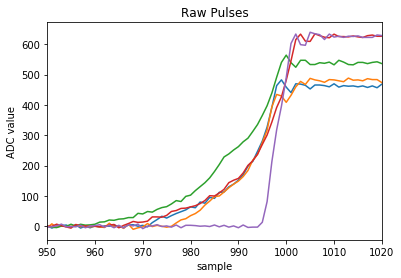

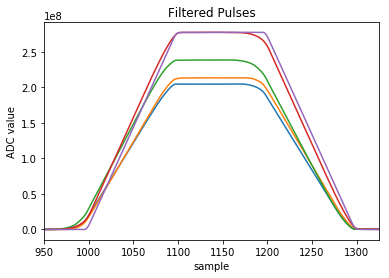

In [306]:
tenevents = read_ten_event_file()
print(tenevents)
for event in tenevents[0:5]:
    event = baseline_correction(event)
    plt.plot(event)
plt.xlim([950, 1020])
plt.title('Raw Pulses')
plt.ylabel('ADC value')
plt.xlabel('sample')
plt.savefig('tenevents_rawdata.pdf')
plt.show()

peaking_time = 100 
gap = 100 
M = 4400
for event in tenevents[0:5]:
    filtered_signal = trapezoidal_filter(event, gap, peaking_time, M)
    plt.figure(41)
    plt.plot(x_values, filtered_signal)
plt.xlim([950, 1325])
plt.title('Filtered Pulses')
plt.ylabel('ADC value')
plt.xlabel('sample')
plt.savefig('tenevents_filtered.pdf')
plt.show()

In [308]:
# filename = 'data/co60.h5'
filename = 'data/DATA_co60_2.h5'
raw_data = import_data(filename)
sampling_time = 10.0
n_data = 4096
x_values = np.linspace(0, n_data, n_data)
M = find_M_value(raw_data, 10)
print(M)
#M = 4400
raw_signal = raw_data[2,:]
signal = baseline_correction(raw_signal)
plt.plot(signal)
plt.show()
peaking_time = 100 
gap = 100 
#M = 4400
filtered_signal = trapezoidal_filter(signal, gap, peaking_time, M)
plt.figure(41)
plt.cla()
plt.clf()
plt.plot(x_values, filtered_signal)
plt.show()
energy = get_energy_value(filtered_signal)
print(energy)

NameError: global name 'BaselineCorrection' is not defined

In [258]:
nrgs = []

number_of_events = len(raw_data)
assert number_of_events <= len(raw_data)
M = find_M_value(raw_data, 10)

k = 100 # peaking time
l = 100 # gap

for i in range(0, number_of_events, 1):
    signal = raw_data[i,:]
    nrg = filter_and_get_energy(signal, l, k, M)
    nrgs.append(round(nrg, 7))

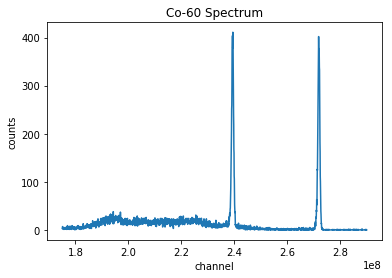

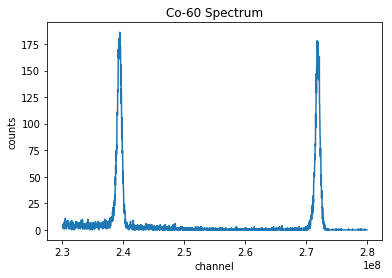

In [263]:
nbins = 2048
counts, bin_edges = np.histogram(nrgs, bins=2048, range=[1.75e8, 2.9e8]) #range=[2.3e8, 2.9e8] WORKS
bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.figure()
plt.plot(bins, counts)
plt.title('Co-60 Spectrum')
plt.ylabel('counts')
plt.xlabel('channel')
plt.savefig('./co60.pdf')
plt.show()

nbins = 2048
counts, bin_edges = np.histogram(nrgs, bins=2048, range=[2.3e8, 2.8e8]) # WORKS
bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.figure()
plt.plot(bins, counts)
plt.title('Co-60 Spectrum')
plt.ylabel('counts')
plt.xlabel('channel')
plt.savefig('./co60.pdf')
plt.show()


In [260]:
def find_peaks(data_x, data_y, low_index, high_index):
    cut_data_y = data_y[low_index:high_index]
    for i in range (low_index,high_index):
        if data_y[i] == max(cut_data_y):
            centerindex =  data_x[i]
            minindex=low_index
            maxindex=high_index
            amplitude = max(cut_data_y)
    ROIrange = [minindex, maxindex]
    return centerindex, amplitude, minindex, maxindex

def calculate_coefficients(calibration_channels, calibration_energies, polynomial_order):
    return np.polyfit(calibration_channels, calibration_energies, polynomial_order)

def calculate_energies(x, m, b):
    energies = m * x + b
    return energies

In [284]:
def get_energy_resolution_co_1173(x, y):
    ROI_low =0
    ROI_high = int(2048 / 2)
    fwhm, center = FitGaussian(x[ROI_low:ROI_high], y[ROI_low:ROI_high])

    return fwhm, center

def get_energy_resolution_co_1332(x, y):
    #i = int(np.argmax(y))
    #ROI_low = int(i + 100)
    ROI_low = int(2048 / 2)
    ROI_high =  2048
    fwhm, center =  FitGaussian(x[ROI_low:ROI_high], y[ROI_low:ROI_high])

    return fwhm, center

def calibrate_co_spectrum(nrgs):# Get first calibration point, ROI HARDCODED
    nbins = 2048
    counts, bin_edges = np.histogram(nrgs, bins=2048, range=[2.3e8, 2.8e8]) # WORKS
    bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    x = bins
    y = counts

    fwhm1, center1 = get_energy_resolution_co_1173(x, y)
    fwhm2, center2 = get_energy_resolution_co_1332(x, y)
    
    # from above fits:
    Co_energies = [1173.2, 1332.5] # MeV
    Co_indices = [center1, center2]
    print (Co_indices)
    
    f = calculate_coefficients(Co_indices, Co_energies, 1)
    print(f)
    m = f[0]
    b = f[1]
    energies = calculate_energies(x, m, b)
    
    return energies


In [272]:
co_energies = calibrate_co_spectrum(nrgs)

[239349385.25251204, 271915008.6747]
[  4.89166131e-06   2.38387355e+00]


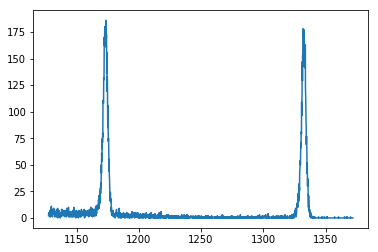

In [273]:
plt.plot(co_energies, counts)
plt.show()

In [276]:
energy_values = []
fwhm_values = []

fwhm, center = get_energy_resolution_co_1332(co_energies, counts)
fwhm_values.append(fwhm)
energy_values.append(center)

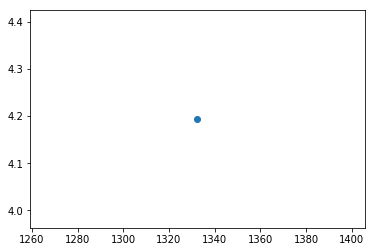

In [277]:
plt.plot(energy_values, fwhm_values, 'o')
plt.show()

In [286]:
import time

In [302]:
#k_values = np.linspace(500, 10000, 2) # steps in 100 ns from 1ns to 10us
start = time.time()
m_values = np.linspace(2000, 100000, 2) # steps in 100 ns from 1ns to 10us
M = find_M_value(raw_data, 10)
print(M)
#M = 4400
end1 = time.time()
print(end1 - start)
k_values = [50]
m_values = np.linspace(1, 70, 20)
fwhm_values = []
m_values_ns = []
k = k_values[0]
for m in m_values:
    print(m)
    m_values_ns.append(m * 10)
    nrgs = []
    number_of_events = len(raw_data)
    assert number_of_events <= len(raw_data)
    for i in range(0, number_of_events, 1):
        signal = raw_data[i,:]
        nrg = filter_and_get_energy(signal, l, k, M)
        nrgs.append(round(nrg, 7))
    end2 = time.time()
    print(end2 - start)
    nbins = 2048
    co_counts, bin_edges = np.histogram(nrgs, bins=2048, range=[2.3e8, 2.8e8]) # WORKS
    bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    end3 = time.time()
    print(end3 - start)
    #co_energies = calibrate_co_spectrum(nrgs)
    #fwhm, center = get_energy_resolution_co_1173(co_energies, co_counts)
    fwhm, center = get_energy_resolution_co_1332(co_energies, co_counts)
    end4 = time.time()
    print(end4 - start)
    fwhm_values.append(fwhm)
    print('end')

# RUNTIME = 25 seconds per m loop

4320.45575167
0.116364955902
1.0
24.6430330276
24.6514589787
24.6857638359
end
4.63157894737
51.2985978127
51.3094158173
51.3353238106
end
8.26315789474
78.6359388828
78.6868138313
78.7441618443
end
11.8947368421
104.645102024
104.661981821
104.688535929
end
15.5263157895
128.644981861
128.649472952
128.666463852
end
19.1578947368
153.105142832
153.115592957
153.179929972
end
22.7894736842
179.180352926
179.193358898
179.231045961
end
26.4210526316
202.534261942
202.537503958
202.55467701
end
30.0526315789
225.865644932
225.871338844
225.890476942
end
33.6842105263
250.318608999
250.322851896
250.348685026
end
37.3157894737
274.215549946
274.228822947
274.25919795
end
40.9473684211
297.379374981
297.392614841
297.418021917
end
44.5789473684
323.093628883
323.102070808
323.2654109
end
48.2105263158
355.757355928
355.779237986
355.819495916
end
51.8421052632
381.090617895
381.097806931
381.120707035
end
55.4736842105
405.897236824
405.912253857
405.931241035
end
59.1052631579
431.8876700

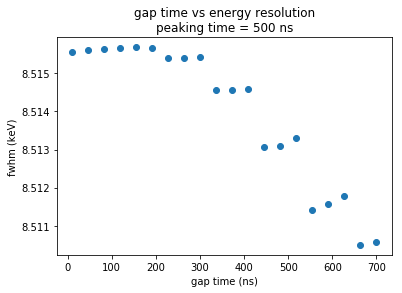

In [303]:
plt.plot(m_values_ns, fwhm_values, 'o')
plt.xlabel('gap time (ns)')
plt.ylabel('fwhm (keV)')
plt.savefig('gap_optimization.png')
plt.title('gap time vs energy resolution' + '\n'  + 'peaking time = 500 ns')
plt.show()

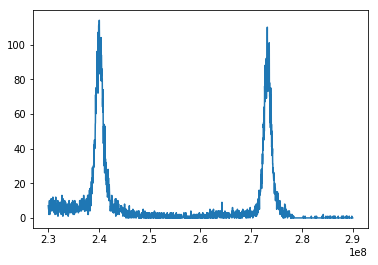

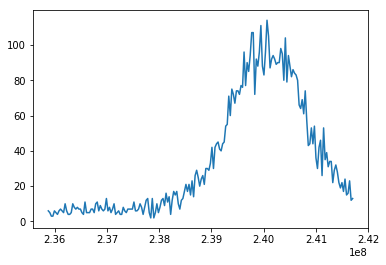

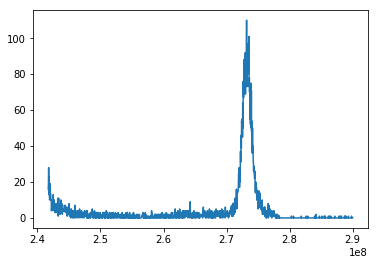

In [327]:
plt.plot(bins, co_counts)
plt.show()
plt.plot(bins[200:400], co_counts[200:400])
plt.show()
plt.plot(bins[400:], co_counts[400:])
plt.show()

In [ ]:
plt.plot(m_values, index, 'o')
plt.show()

In [ ]:
plt.plot(m_values_ns, fwhm_values, 'o')
plt.show()

In [ ]:
plt.plot(m_values_ns, fwhm_values, 'o')
plt.xlabel('gap time (ns)')
plt.title('variable gap with peaking time = 1')
plt.show()

In [ ]:
# END HERE STOP 

In [61]:
#k_values = np.linspace(500, 10000, 2) # steps in 100 ns from 1ns to 10us
m_values = np.linspace(0, 100000, 10) # steps in 100 ns from 1ns to 10us

M = 4400

k = 100
#m_values = np.linspace(1, 10000, 10)

fwhm_values = []
m_values_ns = []
index = []
for m in m_values:
    print(m)
    m_values_ns.append(m * 10)
    nrgs = []
    number_of_events = len(raw_data)
    assert number_of_events <= len(raw_data)

    for i in range(0, number_of_events, 1):
        signal = raw_data[i,:]
        nrg = filter_and_get_energy(signal, l, k, M)
        nrgs.append(round(nrg, 7))
        
    nbins = 2048
    co_counts, bin_edges = np.histogram(nrgs, bins=2048, range=[2.3e8, 2.9e8]) # WORKS
    bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    index.append(np.argmax(co_counts))
   # co_energies = calibrate_co_spectrum(nrgs)
    #fwhm, center = get_energy_resolution_co_1173(co_energies, co_counts)
  #  fwhm, center = get_energy_resolution_co_1332(co_energies, co_counts)
        
  #  fwhm_values.append(fwhm)
        

1107731.52388
38280.8694215


('XVAL', 4096)
('RAW ', 4096)


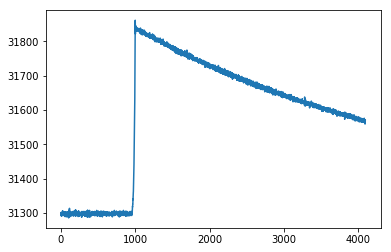

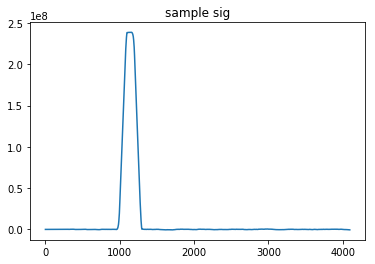

2.38843e+08
('gain = ', 1.0)


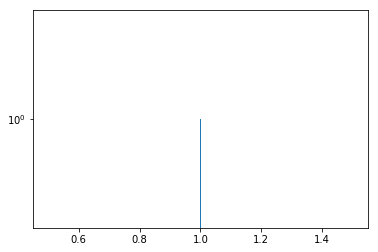

In [78]:

if __name__ == "__main__":

    filename = './DATA_co60_2.h5'
    hf = tables.open_file(filename, "r")

    event_data = hf.root.EventData.read()
    raw_data = hf.root.RawData.read()
    hf.close()

    sampling_time = 10.0
    n_data = 4096
    x_values = np.linspace(0, n_data, n_data)
    print("XVAL" , len(x_values))

    k = 100 # peaking
    m = 100 # gap
    raw_signal = raw_data[2,:]
    print("RAW ", len(raw_signal))
    plt.plot(x_values, raw_signal)
    signal = baseline_correction(raw_signal)
    signal = trapezoidal_filter_2(signal, m, k)

    plt.figure(41)
    plt.cla()
    plt.clf()
    plt.plot(x_values, signal)
    plt.title('sample sig')
    plt.show()

    energy = get_energy_value(signal)
    print(energy)

    nrgs_2 = []
    number_of_events = len(raw_data)
    number_of_events = 1
    assert number_of_events < len(raw_data)
    k = 100 # peaking time
    l = 100 # gap

    for i in range(0, number_of_events, 1):
        gap = 100
        peak = 100
        signal = raw_data[i,:]
        signal = baseline_correction(signal)
        maxval = max(signal)
        signal = signal / maxval
        signal = trapezoidal_filter_2(signal, gap, peak)
        signal = signal / 424829.69
        print('gain = ', max(signal))
        nrg = get_energy_value(signal)
        #nrg = filter_and_get_energy(raw_data[i,:], gap, peak)
        nrgs_2.append(round(nrg, 7))



    plt.hist(nrgs_2, 500, log=True)
    plt.show()